## Analysis of runtimes of modules on different servers
This scripts reads in two log files which look like this: 

In [1]:
# Task: PreprocessingGatewayQuantileMapping
# Start Time: 2025-02-12T10:04:24.240141
# End Time: 2025-02-12T10:05:36.792742
# Duration: 72.55 seconds
# Status: Success
# Details: Completed on attempt 1
# --------------------------------------------------
# Task: ConceptualModel
# Start Time: 2025-02-12T10:05:36.797761
# End Time: 2025-02-12T10:06:37.473160
# Duration: 60.68 seconds
# Status: Failed
# Details:
# --------------------------------------------------
# Task: RunMLModel_TSMIXER_PENTAD
# Start Time: 2025-02-12T10:06:37.481804
# End Time: 2025-02-12T10:08:53.059385
# Duration: 135.58 seconds
# Status: Failed
# Details: 'RunMLModel' object has no attribute 'run_with_timeout'
# --------------------------------------------------

We want to read the log files and store the information in a pandas dataframe. We only keep information about tasks with Status: Success. We visualize the Duration for each task on each server. 
We further compare the latest runtimes of each task on the two servers.

In [2]:
import os
import pandas as pd
import re
from datetime import datetime

def parse_task_log(file_path):
    """Parse task timing log file into a structured DataFrame."""
    with open(file_path, 'r') as f:
        content = f.read()

    # Split the content by task blocks
    tasks = content.split('--------------------------------------------------')

    # Prepare data for DataFrame
    data = []

    for task_block in tasks:
        if task_block.strip() == '':
            continue

        # Extract task name
        task_match = re.search(r'Task: (.+)', task_block)
        if not task_match:
            continue
        task_name = task_match.group(1).strip()

        # Extract start time
        start_match = re.search(r'Start Time: (.+)', task_block)
        start_time = start_match.group(1).strip() if start_match else None

        # Extract end time
        end_match = re.search(r'End Time: (.+)', task_block)
        end_time = end_match.group(1).strip() if end_match else None

        # Extract duration
        duration_match = re.search(r'Duration: (.+) seconds', task_block)
        duration = float(duration_match.group(1).strip()) if duration_match else None

        # Extract status
        status_match = re.search(r'Status: (.+)', task_block)
        status = status_match.group(1).strip() if status_match else None

        # Extract details
        details_match = re.search(r'Details: (.+)', task_block)
        details = details_match.group(1).strip() if details_match else None

        # Convert times to datetime objects
        start_datetime = datetime.fromisoformat(start_time) if start_time else None
        end_datetime = datetime.fromisoformat(end_time) if end_time else None

        # Calculate run sequence group (each full pipeline run is a group)
        # We'll define new groups when 'LogFileCleanup' or 'DeleteOldGatewayFiles' appears

        data.append({
            'Task': task_name,
            'Start Time': start_datetime,
            'End Time': end_datetime,
            'Duration (s)': duration,
            'Status': status,
            'Details': details
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Add run_group column to identify separate pipeline runs
    df['run_index'] = 0
    current_run = 0

    # A new run starts after a SendPipelineCompletionNotification or at the beginning
    for i in range(len(df)):
        if i > 0 and df.iloc[i-1]['Task'] == 'SendPipelineCompletionNotification':
            current_run += 1
        df.iloc[i, df.columns.get_loc('run_index')] = current_run

    return df




In [3]:
# print current directory
print(os.getcwd())

# Parse ZH log file
zh_log_path = '../../../../sensitive_data_forecast_tools/intermediate_data/task_timings_ZH_20250319.log'
if os.path.exists(zh_log_path):
    data_zh = parse_task_log(zh_log_path)
else:
    print(f"ZH log file not found at {zh_log_path}")
    data_zh = None

# Parse KG log file (if it's different from ZH - currently using the same file in your example)
kg_log_path = '../../../../sensitive_data_forecast_tools/intermediate_data/task_timings_ZH_20250319.log'
if os.path.exists(kg_log_path):
    data_kg = parse_task_log(kg_log_path)
else:
    print(f"KG log file not found at {kg_log_path}")
    data_kg = None

# Display basic statistics
print(f"ZH Log Analysis:\n")
print(f"Total number of tasks: {len(data_zh)}")
print(f"Number of pipeline runs: {data_zh['run_index'].max() + 1}")
print(f"Total runtime across all tasks: {data_zh['Duration (s)'].sum():.2f} seconds")
print("\nTop 5 longest running tasks:")
print(data_zh.sort_values('Duration (s)', ascending=False).head())


/Users/bea/Documents/GitHub/SAPPHIRE_forecast_tools/apps/backend/tests
ZH Log Analysis:

Total number of tasks: 815
Number of pipeline runs: 30
Total runtime across all tasks: 77130.48 seconds

Top 5 longest running tasks:
                Task                 Start Time                   End Time  \
333  ConceptualModel 2025-03-07 12:15:51.586721 2025-03-07 12:37:09.706779   
349  ConceptualModel 2025-03-07 13:40:18.744937 2025-03-07 13:53:12.242130   
365  ConceptualModel 2025-03-07 14:15:13.391457 2025-03-07 14:28:00.009567   
389  ConceptualModel 2025-03-07 17:02:22.831086 2025-03-07 17:14:43.243922   
110  ConceptualModel 2025-03-05 14:46:02.060271 2025-03-05 14:58:21.100333   

     Duration (s)   Status                 Details  run_index  
333       1278.12  Success  Completed on attempt 1          4  
349        773.50  Success  Completed on attempt 1          4  
365        766.62  Success  Completed on attempt 1          4  
389        740.41  Success  Completed on attempt 1  

/Users/bea/anaconda3/envs/hsol_py310/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import gaussian_kde


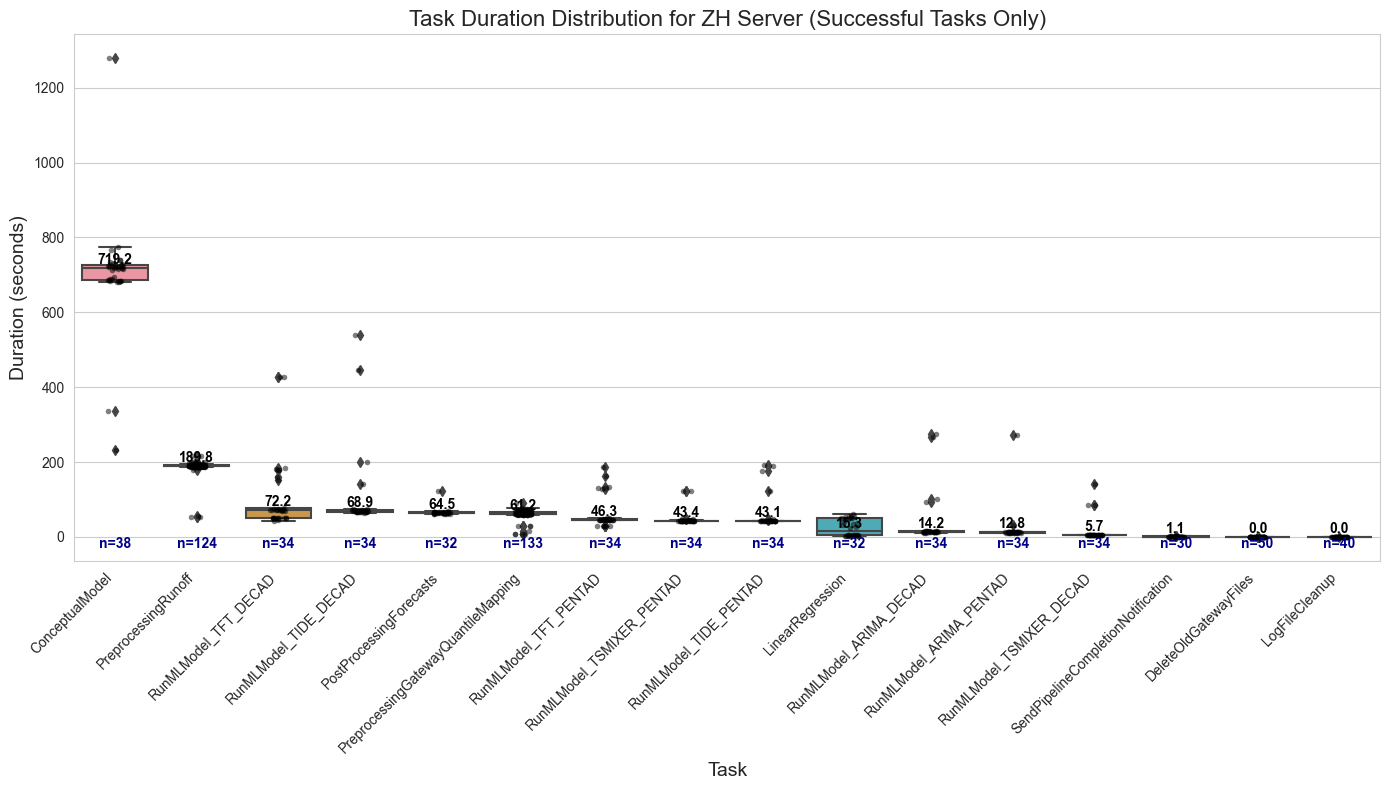

In [4]:
# Plot durations by task type using boxplots for successful tasks only
if not data_zh.empty:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import warnings

    # Suppress specific warnings
    warnings.filterwarnings("ignore", category=UserWarning, message="A NumPy version")
    warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
    warnings.filterwarnings("ignore", category=FutureWarning, message="When grouping with a length-1 list-like")

    # Filter data to include only successful tasks
    success_data = data_zh[data_zh['Status'] == 'Success'].copy()

    # Replace any potential inf values with NaN (addressing one warning)
    success_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Only proceed if we have successful tasks
    if not success_data.empty:
        # Set a better visual style
        sns.set_style("whitegrid")

        # Create a boxplot of task durations
        plt.figure(figsize=(14, 8))

        # Sort tasks by median duration for better visualization
        task_order = success_data.groupby('Task')['Duration (s)'].median().sort_values(ascending=False).index.tolist()

        # Create the boxplot with seaborn
        ax = sns.boxplot(x='Task', y='Duration (s)', data=success_data, order=task_order)

        # Add individual data points for better visibility with small dataset
        sns.stripplot(x='Task', y='Duration (s)', data=success_data, color='black',
                     size=4, alpha=0.5, order=task_order)

        # Add labels and title
        plt.title('Task Duration Distribution for ZH Server (Successful Tasks Only)', fontsize=16)
        plt.ylabel('Duration (seconds)', fontsize=14)
        plt.xlabel('Task', fontsize=14)
        plt.xticks(rotation=45, ha='right')

        # Add median values on top of boxes
        # Using dict comprehension instead of Series to avoid groupby warning
        medians = {task: success_data[success_data['Task'] == task]['Duration (s)'].median()
                  for task in task_order}

        for i, task in enumerate(task_order):
            plt.text(i, medians[task]+10, f'{medians[task]:.1f}',
                    horizontalalignment='center', color='black', fontweight='bold')

        # Add count of each task
        # Using value_counts + dict to avoid reindex warning
        task_counts = success_data['Task'].value_counts().to_dict()

        for i, task in enumerate(task_order):
            plt.text(i, -30, f'n={task_counts.get(task, 0)}',
                    horizontalalignment='center', color='darkblue', fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("No successful tasks found in the data.")
else:
    print("No data available for plotting.")

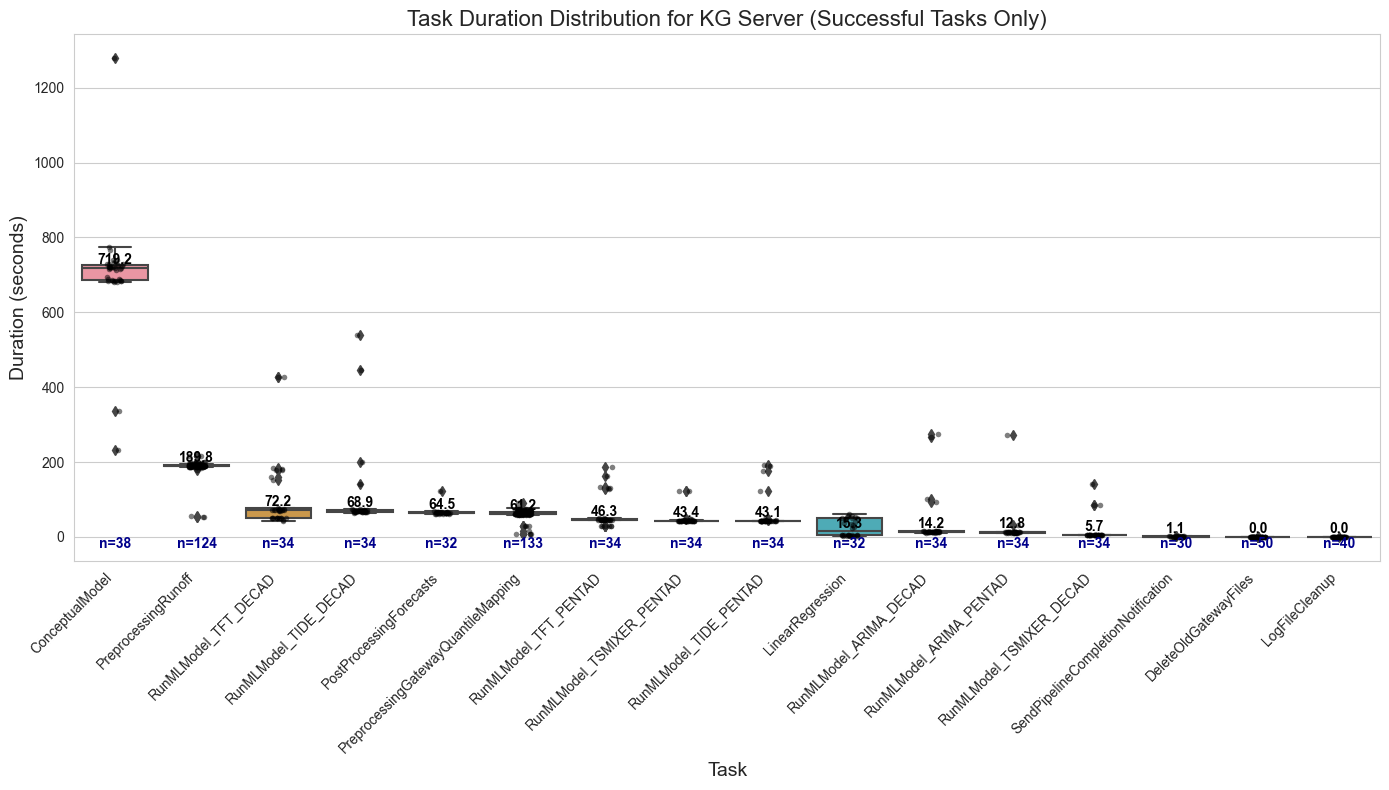

In [5]:
# Plot durations by task type using boxplots for successful tasks only
if not data_kg.empty:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import warnings

    # Suppress specific warnings
    warnings.filterwarnings("ignore", category=UserWarning, message="A NumPy version")
    warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
    warnings.filterwarnings("ignore", category=FutureWarning, message="When grouping with a length-1 list-like")

    # Filter data to include only successful tasks
    success_data = data_kg[data_zh['Status'] == 'Success'].copy()

    # Replace any potential inf values with NaN (addressing one warning)
    success_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Only proceed if we have successful tasks
    if not success_data.empty:
        # Set a better visual style
        sns.set_style("whitegrid")

        # Create a boxplot of task durations
        plt.figure(figsize=(14, 8))

        # Sort tasks by median duration for better visualization
        task_order = success_data.groupby('Task')['Duration (s)'].median().sort_values(ascending=False).index.tolist()

        # Create the boxplot with seaborn
        ax = sns.boxplot(x='Task', y='Duration (s)', data=success_data, order=task_order)

        # Add individual data points for better visibility with small dataset
        sns.stripplot(x='Task', y='Duration (s)', data=success_data, color='black',
                     size=4, alpha=0.5, order=task_order)

        # Add labels and title
        plt.title('Task Duration Distribution for KG Server (Successful Tasks Only)', fontsize=16)
        plt.ylabel('Duration (seconds)', fontsize=14)
        plt.xlabel('Task', fontsize=14)
        plt.xticks(rotation=45, ha='right')

        # Add median values on top of boxes
        # Using dict comprehension instead of Series to avoid groupby warning
        medians = {task: success_data[success_data['Task'] == task]['Duration (s)'].median()
                  for task in task_order}

        for i, task in enumerate(task_order):
            plt.text(i, medians[task]+10, f'{medians[task]:.1f}',
                    horizontalalignment='center', color='black', fontweight='bold')

        # Add count of each task
        # Using value_counts + dict to avoid reindex warning
        task_counts = success_data['Task'].value_counts().to_dict()

        for i, task in enumerate(task_order):
            plt.text(i, -30, f'n={task_counts.get(task, 0)}',
                    horizontalalignment='center', color='darkblue', fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("No successful tasks found in the data.")
else:
    print("No data available for plotting.")

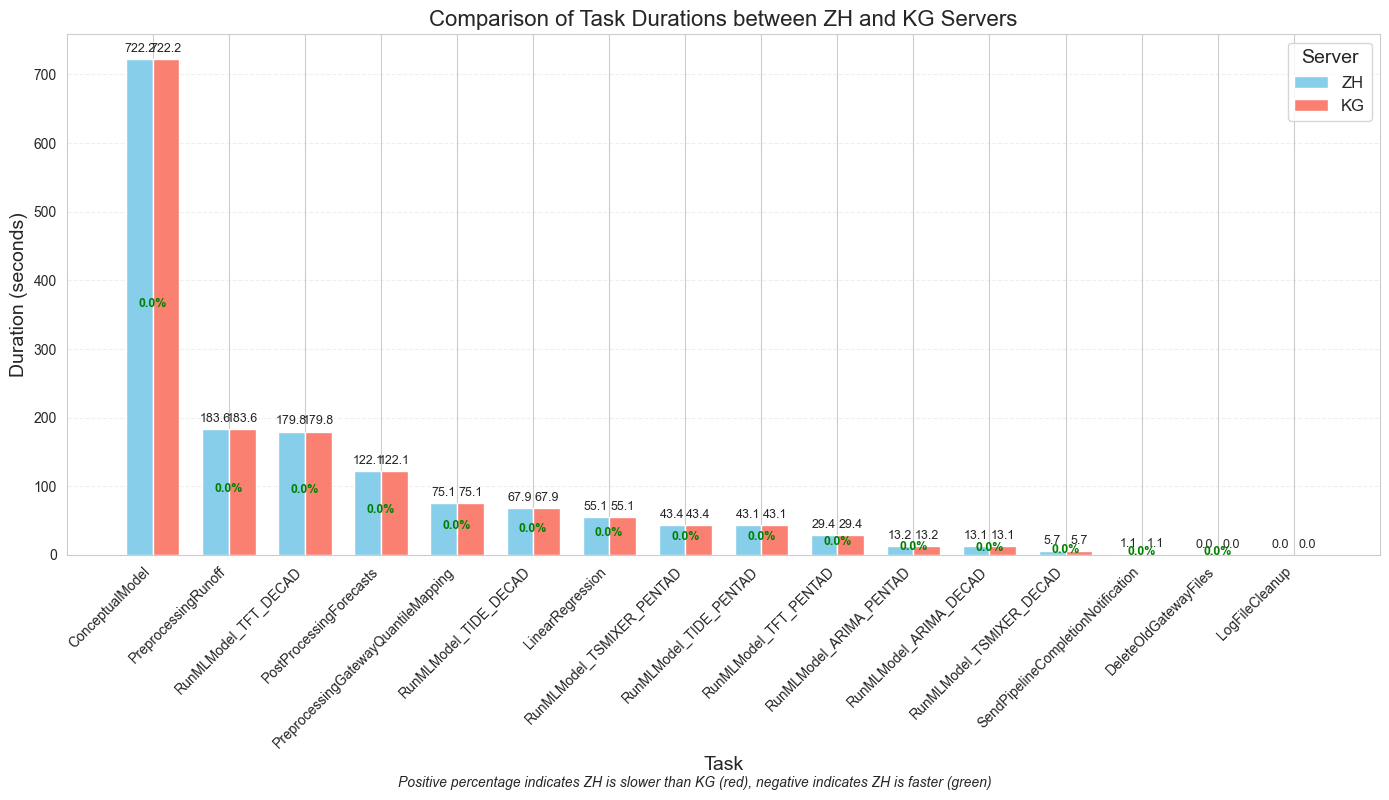


Comparison of Task Durations between ZH and KG Servers:


/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_84944/4109138410.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table['Percentage Difference'] = comparison_table['Percentage Difference'].map('{:.1f}%'.format)


,Task,Duration (s)_ZH,Duration (s)_KG,Duration Difference,Percentage Difference
0,ConceptualModel,722.17,722.17,0.0,0.0%
1,DeleteOldGatewayFiles,0.01,0.01,0.0,0.0%
2,LinearRegression,55.08,55.08,0.0,0.0%
3,LogFileCleanup,0.00,0.00,0.0,nan%
4,PostProcessingForecasts,122.13,122.13,0.0,0.0%
5,PreprocessingGatewayQuantileMapping,75.13,75.13,0.0,0.0%
6,PreprocessingRunoff,183.58,183.58,0.0,0.0%
7,RunMLModel_ARIMA_DECAD,13.08,13.08,0.0,0.0%
8,RunMLModel_ARIMA_PENTAD,13.25,13.25,0.0,0.0%
9,RunMLModel_TFT_DECAD,179.80,179.80,0.0,0.0%


In [6]:
# Compare the last Duration for each task between ZH and KG
if not data_zh.empty and not data_kg.empty:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings

    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Filter to include only the last run for each task
    last_zh = data_zh.loc[data_zh.groupby('Task')['run_index'].idxmax()]
    last_kg = data_kg.loc[data_kg.groupby('Task')['run_index'].idxmax()]

    # Merge the two datasets on the 'Task' column
    merged = last_zh.merge(last_kg, on='Task', suffixes=('_ZH', '_KG'), how='outer')

    # Calculate the difference in duration between the two servers
    merged['Duration Difference'] = merged['Duration (s)_ZH'] - merged['Duration (s)_KG']

    # Calculate percentage difference
    merged['Percentage Difference'] = (merged['Duration Difference'] / merged['Duration (s)_KG'] * 100)

    # Sort tasks by average duration
    avg_duration = (merged['Duration (s)_ZH'].fillna(0) + merged['Duration (s)_KG'].fillna(0)) / 2
    merged['avg_duration'] = avg_duration
    merged = merged.sort_values('avg_duration', ascending=False)
    task_order = merged['Task'].tolist()

    # Create figure with matplotlib (to avoid seaborn's overlapping)
    fig, ax = plt.subplots(figsize=(14, 8))

    # Set width and positions
    width = 0.35
    x = np.arange(len(task_order))

    # Create side-by-side bars
    rects1 = ax.bar(x - width/2, merged['Duration (s)_ZH'], width, label='ZH', color='skyblue')
    rects2 = ax.bar(x + width/2, merged['Duration (s)_KG'], width, label='KG', color='salmon')

    # Add labels and title
    ax.set_title('Comparison of Task Durations between ZH and KG Servers', fontsize=16)
    ax.set_ylabel('Duration (seconds)', fontsize=14)
    ax.set_xlabel('Task', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(task_order, rotation=45, ha='right')
    ax.legend(title='Server', title_fontsize='14', fontsize='12')

    # Add duration values on top of bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):  # Skip if NaN
                ax.annotate(f'{height:.1f}',
                           xy=(rect.get_x() + rect.get_width()/2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)

    add_labels(rects1)
    add_labels(rects2)

    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Add difference percentage as text between bars
    for i, task in enumerate(task_order):
        row = merged[merged['Task'] == task].iloc[0]
        if not np.isnan(row['Percentage Difference']):
            # Only show if both ZH and KG have values
            if not np.isnan(row['Duration (s)_ZH']) and not np.isnan(row['Duration (s)_KG']):
                color = 'red' if row['Percentage Difference'] > 0 else 'green'
                ax.annotate(f"{row['Percentage Difference']:.1f}%",
                           xy=(i, min(row['Duration (s)_ZH'], row['Duration (s)_KG'])/2),
                           ha='center', fontsize=9, color=color, fontweight='bold')

    # Add subtitle with explanation
    plt.figtext(0.5, 0.01,
               "Positive percentage indicates ZH is slower than KG (red), negative indicates ZH is faster (green)",
               ha="center", fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Make room for the subtitle
    plt.show()

    # Display the numerical comparison as a table
    print("\nComparison of Task Durations between ZH and KG Servers:")
    comparison_table = merged[['Task', 'Duration (s)_ZH', 'Duration (s)_KG',
                             'Duration Difference', 'Percentage Difference']]
    comparison_table['Percentage Difference'] = comparison_table['Percentage Difference'].map('{:.1f}%'.format)
    display(comparison_table.sort_values('Task'))

else:
    print("No data available for comparison.")